<a href="https://colab.research.google.com/github/patriani/RNN_LSTM_Tesla_stock/blob/main/ELT575_Semana3_ES119663.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas

In [1]:
from pandas import read_csv
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import pandas as pd

# Primeira configuração da rede
- Modelo de RNN configurado com apenas uma célula de LSTM, que por sua vez possui 50 unidades ocultas.
- Análise:

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
def load_and_prepare_data():

  tesla_stock = 'https://raw.githubusercontent.com/patriani/RNN_LSTM_Tesla_stock/main/tesla_stock_2015_2022.csv'
  df = read_csv(tesla_stock)

  # Only the column 'Open' will be used as independent variables and 'Close' is the column of the dependent variables.
  df_XY=pd.DataFrame(df, columns=['Open','Close'])

  # Reshape of the target data
  df_XY_scaled = scaler.fit_transform(df_XY.values.reshape(-1, 1))

  # Split into train and test data (80% to train and 20% to test)
  train_size = int(len(df_XY_scaled) * 0.8)
  train_data = df_XY_scaled[:train_size]
  test_data = df_XY_scaled[train_size:]

  return df_XY,train_data,test_data

df_XY,train_data,test_data = load_and_prepare_data()

In [14]:
# Prepare the input X and target Y
def get_XY(data, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(data), time_steps)
    Y = data[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = data[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))
    return X, Y

time_steps = 50

# Prepating the train data frame
trainX, trainY = get_XY(train_data, time_steps)

# Prepating the test data frame
testX, testY = get_XY(test_data, time_steps)

In [15]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    # Parameter return_sequences=True => SimpleRNN layer returns sequences so that the output has the same number of time steps as the input, making it compatible with the second SimpleRNN layer
    model.add(LSTM(hidden_units, input_shape=input_shape,activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),activation=['tanh', 'tanh'])
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=32, verbose=2)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 - 1s - 633ms/step - loss: 0.0042 - val_loss: 0.2909
Epoch 2/20
2/2 - 0s - 49ms/step - loss: 0.0024 - val_loss: 0.2173
Epoch 3/20
2/2 - 0s - 70ms/step - loss: 0.0018 - val_loss: 0.1608
Epoch 4/20
2/2 - 0s - 69ms/step - loss: 0.0018 - val_loss: 0.1227
Epoch 5/20
2/2 - 0s - 41ms/step - loss: 0.0016 - val_loss: 0.1011
Epoch 6/20
2/2 - 0s - 39ms/step - loss: 0.0011 - val_loss: 0.0865
Epoch 7/20
2/2 - 0s - 70ms/step - loss: 7.0328e-04 - val_loss: 0.0719
Epoch 8/20
2/2 - 0s - 39ms/step - loss: 5.0893e-04 - val_loss: 0.0560
Epoch 9/20
2/2 - 0s - 71ms/step - loss: 4.1107e-04 - val_loss: 0.0378
Epoch 10/20
2/2 - 0s - 39ms/step - loss: 2.9138e-04 - val_loss: 0.0204
Epoch 11/20
2/2 - 0s - 70ms/step - loss: 1.1715e-04 - val_loss: 0.0082
Epoch 12/20
2/2 - 0s - 67ms/step - loss: 7.1221e-05 - val_loss: 0.0040
Epoch 13/20
2/2 - 0s - 39ms/step - loss: 1.2259e-04 - val_loss: 0.0037
Epoch 14/20
2/2 - 0s - 75ms/step - loss: 1.6687e-04 - val_loss: 0.0036
Epoch 15/20
2/2 - 0s - 56ms/step - loss: 1.1129e-

In [16]:
def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Raíz do Erro Médio Quadrático para Treino: %.3f' % (train_rmse))
    print('Raíz do Erro Médio Quadrático para Teste: %.3f' % (test_rmse))

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Raíz do Erro Médio Quadrático para Treino: 0.008
Raíz do Erro Médio Quadrático para Teste: 0.108


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


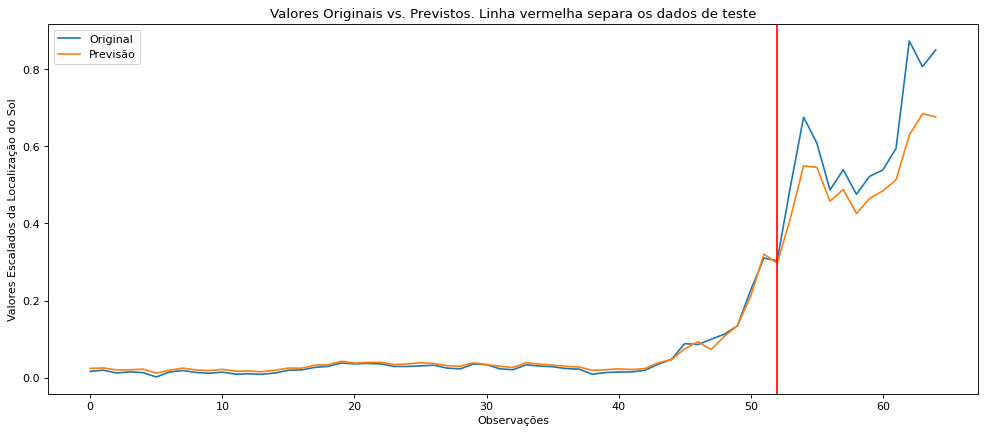

In [17]:
# predicting
predicted = model.predict(trainX)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(testY.reshape(-1, 1))

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Original', 'Previsão'])
    plt.xlabel('Observações')
    plt.ylabel('Valores Escalados da Localização do Sol')
    plt.title('Valores Originais vs. Previstos. Linha vermelha separa os dados de teste')

plot_result(trainY, testY, train_predict, test_predict)

# Segunda análise
- Experimento com adição de uma camada LSTM

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 - 2s - 995ms/step - loss: 0.0050 - val_loss: 0.2830
Epoch 2/20
2/2 - 0s - 42ms/step - loss: 0.0023 - val_loss: 0.1612
Epoch 3/20
2/2 - 0s - 50ms/step - loss: 0.0019 - val_loss: 0.0988
Epoch 4/20
2/2 - 0s - 84ms/step - loss: 0.0013 - val_loss: 0.0671
Epoch 5/20
2/2 - 0s - 49ms/step - loss: 5.1942e-04 - val_loss: 0.0372
Epoch 6/20
2/2 - 0s - 70ms/step - loss: 3.0767e-04 - val_loss: 0.0129
Epoch 7/20
2/2 - 0s - 45ms/step - loss: 2.9966e-04 - val_loss: 0.0038
Epoch 8/20
2/2 - 0s - 43ms/step - loss: 1.3213e-04 - val_loss: 0.0073
Epoch 9/20
2/2 - 0s - 72ms/step - loss: 3.7577e-04 - val_loss: 0.0070
Epoch 10/20
2/2 - 0s - 44ms/step - loss: 3.2032e-04 - val_loss: 0.0039
Epoch 11/20
2/2 - 0s - 43ms/step - loss: 8.4999e-05 - val_loss: 0.0061
Epoch 12/20
2/2 - 0s - 49ms/step - loss: 1.2341e-04 - val_loss: 0.0129
Epoch 13/20
2/2 - 0s - 63ms/step - loss: 1.2361e-04 - val_loss: 0.0181
Epoch 14/20
2/2 - 0s - 74ms/step - loss: 9.6537e-05 - val_loss: 0.0204
Epoch 15/20
2/2 - 0s - 65ms/step - loss: 

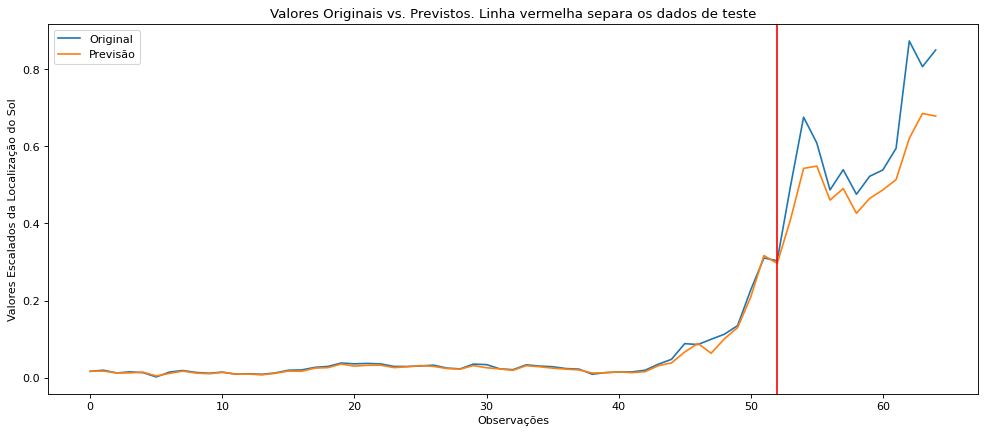

In [18]:

df_XY_02,train_data_02,test_data_02 = load_and_prepare_data()

# Same value of the previous test
time_steps = 50

# Prepating the train data frame
trainX_02, trainY_02 = get_XY(train_data_02, time_steps)

# Prepating the test data frame
testX_02, testY_02 = get_XY(test_data_02, time_steps)

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    # Parameter return_sequences=True => SimpleRNN layer returns sequences so that the output has the same number of time steps as the input, making it compatible with the second SimpleRNN layer
    model.add(LSTM(hidden_units, input_shape=input_shape,activation=activation[0],return_sequences=True))
    #model.add(Dropout(0.2))
    model.add(LSTM(hidden_units, activation=activation[1]))
    #model.add(Dropout(0.2))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model_02 = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),activation=['tanh', 'tanh'])
history = model_02.fit(trainX_02, trainY_02, validation_data=(testX_02, testY_02), epochs=20, batch_size=32, verbose=2)


# make predictions
train_predict_02 = model_02.predict(trainX_02)
test_predict_02 = model_02.predict(testX_02)
# Mean square error
print_error(trainY_02, testY_02, train_predict_02, test_predict_02)


# predicting
predicted_02 = model_02.predict(trainX_02)
predicted_prices_02 = scaler.inverse_transform(predicted_02)
actual_prices_02 = scaler.inverse_transform(testY.reshape(-1, 1))

# Plot the result
plot_result(trainY_02, testY_02, train_predict_02, test_predict_02)

# Terceira análise
- O modelo_02 será modificado, tendo camadas de Dropout de 20% incluídas


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 - 3s - 2s/step - loss: 0.0061 - val_loss: 0.3809
Epoch 2/20
2/2 - 0s - 44ms/step - loss: 0.0031 - val_loss: 0.2434
Epoch 3/20
2/2 - 0s - 64ms/step - loss: 0.0029 - val_loss: 0.1656
Epoch 4/20
2/2 - 0s - 44ms/step - loss: 0.0020 - val_loss: 0.1318
Epoch 5/20
2/2 - 0s - 70ms/step - loss: 0.0013 - val_loss: 0.1105
Epoch 6/20
2/2 - 0s - 78ms/step - loss: 9.1309e-04 - val_loss: 0.0853
Epoch 7/20
2/2 - 0s - 66ms/step - loss: 5.7369e-04 - val_loss: 0.0556
Epoch 8/20
2/2 - 0s - 66ms/step - loss: 3.5045e-04 - val_loss: 0.0291
Epoch 9/20
2/2 - 0s - 69ms/step - loss: 2.1920e-04 - val_loss: 0.0106
Epoch 10/20
2/2 - 0s - 43ms/step - loss: 1.3386e-04 - val_loss: 0.0048
Epoch 11/20
2/2 - 0s - 70ms/step - loss: 2.4615e-04 - val_loss: 0.0067
Epoch 12/20
2/2 - 0s - 70ms/step - loss: 6.1134e-04 - val_loss: 0.0054
Epoch 13/20
2/2 - 0s - 69ms/step - loss: 6.6874e-04 - val_loss: 0.0057
Epoch 14/20
2/2 - 0s - 49ms/step - loss: 2.1386e-04 - val_loss: 0.0119
Epoch 15/20
2/2 - 0s - 67ms/step - loss: 2.7159e

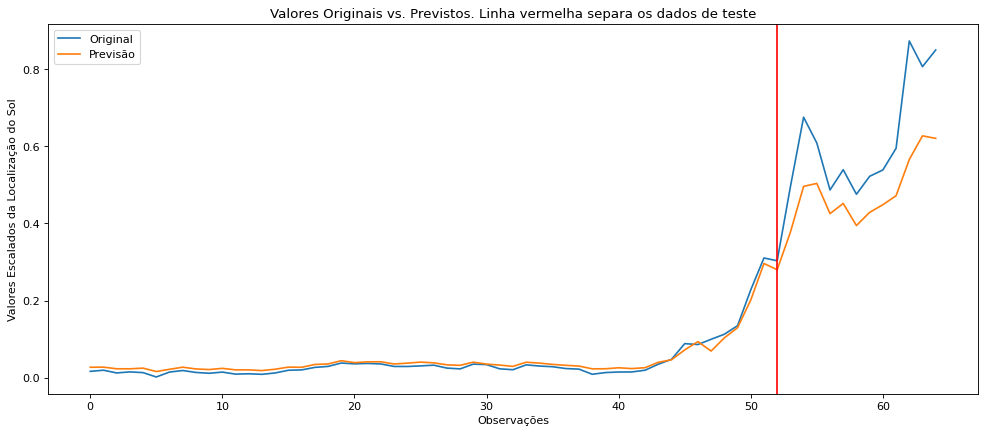

In [19]:

df_XY_03,train_data_03,test_data_03 = load_and_prepare_data()

# Same value of the previous test
time_steps = 50

# Prepating the train data frame
trainX_03, trainY_03 = get_XY(train_data_03, time_steps)

# Prepating the test data frame
testX_03, testY_03 = get_XY(test_data_03, time_steps)

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    # Parameter return_sequences=True => SimpleRNN layer returns sequences so that the output has the same number of time steps as the input, making it compatible with the second SimpleRNN layer
    model.add(LSTM(hidden_units, input_shape=input_shape,activation=activation[0],return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(hidden_units, activation=activation[1]))
    model.add(Dropout(0.2))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model_03 = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),activation=['tanh', 'tanh'])
history = model_03.fit(trainX_03, trainY_03, validation_data=(testX_03, testY_03), epochs=20, batch_size=32, verbose=2)


# make predictions
train_predict_03 = model_03.predict(trainX_03)
test_predict_03 = model_03.predict(testX_03)
# Mean square error
print_error(trainY_03, testY_03, train_predict_03, test_predict_03)


# predicting
predicted_03 = model_03.predict(trainX_03)
predicted_prices_03 = scaler.inverse_transform(predicted_03)
actual_prices_03 = scaler.inverse_transform(testY.reshape(-1, 1))

# Plot the result
plot_result(trainY_03, testY_03, train_predict_03, test_predict_03)

# Quarta análise
- modelo04, com 4 blocos de LSTM

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 - 4s - 2s/step - loss: 0.0039 - val_loss: 0.2356
Epoch 2/20
2/2 - 0s - 54ms/step - loss: 0.0018 - val_loss: 0.1456
Epoch 3/20
2/2 - 0s - 73ms/step - loss: 0.0017 - val_loss: 0.0989
Epoch 4/20
2/2 - 0s - 129ms/step - loss: 9.4048e-04 - val_loss: 0.0528
Epoch 5/20
2/2 - 0s - 73ms/step - loss: 6.5192e-04 - val_loss: 0.0104
Epoch 6/20
2/2 - 0s - 53ms/step - loss: 2.6141e-04 - val_loss: 0.0099
Epoch 7/20
2/2 - 0s - 53ms/step - loss: 4.6772e-04 - val_loss: 0.0124
Epoch 8/20
2/2 - 0s - 76ms/step - loss: 3.0582e-04 - val_loss: 0.0253
Epoch 9/20
2/2 - 0s - 54ms/step - loss: 2.1035e-04 - val_loss: 0.0328
Epoch 10/20
2/2 - 0s - 72ms/step - loss: 1.7291e-04 - val_loss: 0.0289
Epoch 11/20
2/2 - 0s - 56ms/step - loss: 1.9343e-04 - val_loss: 0.0240
Epoch 12/20
2/2 - 0s - 53ms/step - loss: 1.8989e-04 - val_loss: 0.0229
Epoch 13/20
2/2 - 0s - 54ms/step - loss: 2.3437e-04 - val_loss: 0.0188
Epoch 14/20
2/2 - 0s - 73ms/step - loss: 1.0235e-04 - val_loss: 0.0133
Epoch 15/20
2/2 - 0s - 52ms/step - loss

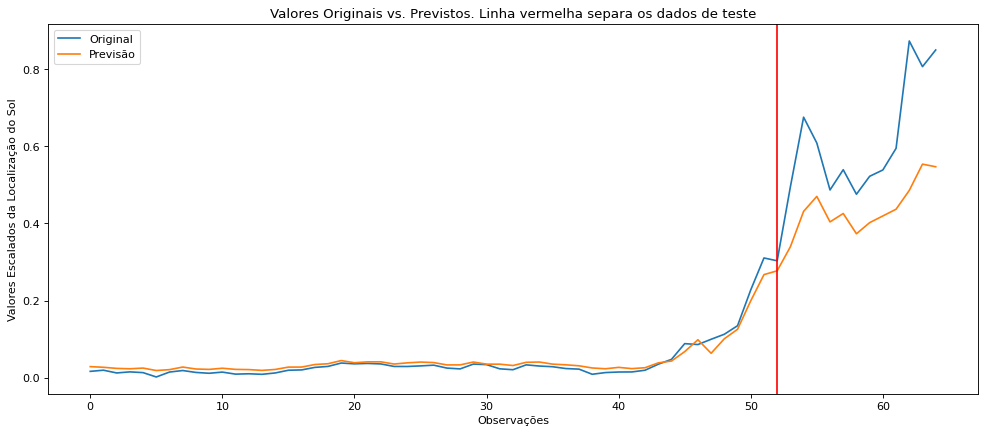

In [21]:

df_XY_04,train_data_04,test_data_04 = load_and_prepare_data()

# Same value of the previous test
time_steps = 50

# Prepating the train data frame
trainX_04, trainY_04 = get_XY(train_data_04, time_steps)

# Prepating the test data frame
testX_04, testY_04 = get_XY(test_data_04, time_steps)

def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    # Parameter return_sequences=True => SimpleRNN layer returns sequences so that the output has the same number of time steps as the input, making it compatible with the second SimpleRNN layer
    model.add(LSTM(hidden_units, input_shape=input_shape,activation=activation[0],return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(hidden_units, activation=activation[1],return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(hidden_units, activation=activation[1],return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(hidden_units, activation=activation[1]))
    model.add(Dropout(0.2))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model_04 = create_RNN(hidden_units=50, dense_units=1, input_shape=(time_steps,1),activation=['tanh', 'tanh'])
history = model_04.fit(trainX_04, trainY_04, validation_data=(testX_04, testY_04), epochs=20, batch_size=32, verbose=2)


# make predictions
train_predict_04 = model_04.predict(trainX_04)
test_predict_04 = model_04.predict(testX_04)
# Mean square error
print_error(trainY_04, testY_04, train_predict_04, test_predict_04)


# predicting
predicted_04 = model_04.predict(trainX_04)
predicted_prices_04 = scaler.inverse_transform(predicted_04)
actual_prices_04 = scaler.inverse_transform(testY.reshape(-1, 1))

# Plot the result
plot_result(trainY_04, testY_04, train_predict_04, test_predict_04)